<a href="https://colab.research.google.com/github/jiobu1/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/Jisha_Obukwelu_DSPT3_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

##1. Load and clean the data (or determine the best method to drop observations when running tests)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel


In [3]:
from google.colab import files
upload = files.upload()

Saving house-votes-84-data to house-votes-84-data


####Finding Column Names
Column Names
1. Class Name: 2 (democrat, republican)
2. handicapped-infants: 2 (y,n)
3. water-project-cost-sharing: 2 (y,n)
4. adoption-of-the-budget-resolution: 2 (y,n)
5. physician-fee-freeze: 2 (y,n)
6. el-salvador-aid: 2 (y,n)
7. religious-groups-in-schools: 2 (y,n)
8. anti-satellite-test-ban: 2 (y,n)
9. aid-to-nicaraguan-contras: 2 (y,n)
10. mx-missile: 2 (y,n)
11. immigration: 2 (y,n)
12. synfuels-corporation-cutback: 2 (y,n)
13. education-spending: 2 (y,n)
14. superfund-right-to-sue: 2 (y,n)
15. crime: 2 (y,n)
16. duty-free-exports: 2 (y,n)
17. export-administration-act-south-africa: 2 (y,n)

In [4]:
#Loading dataset and creating header names
column_heads = ['Party', 'handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 
                'physician-fee-freeze', 'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 
                'aid-to-nicaraguan-contras','mx-missile', 'immigration', 'synfuels-corporation-cutback', 
                'education-spending', 'superfund-right-to-sue', 'crime', 'duty-free-exports', 'export-administration-act-south-africa']
                
house_votes = pd.read_csv('house-votes-84-data')
house_votes.columns = column_heads
house_votes.head()

,Party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


In [5]:
house_votes.describe(exclude='number')

,Party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,235,194,253,247,211,271,239,242,207,215,264,233,208,247,232,268


In [6]:
house_votes.shape

(434, 17)

###Cleaning: NaN and converting string to int

In [7]:
mymap = {'y':1, 'n':0, '?':np.NaN}
house_votes = house_votes.applymap(lambda s: mymap.get(s) if s in mymap else s)             
house_votes.head()

,Party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
1,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
4,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [8]:
#No votes
house_votes.isnull().sum()

Party                                       0
handicapped-infants                        12
water-project-cost-sharing                 48
adoption-of-the-budget-resolution          11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               20
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
export-administration-act-south-africa    104
dtype: int64

###Separating data into democrat and republicans for further analysis

In [0]:
republicans = house_votes[house_votes['Party'] == 'republican']
democrats = house_votes[house_votes['Party'] == 'democrat']

In [10]:
republicans.shape

(167, 17)

In [11]:
republicans = republicans.drop(['Party'], axis=1)
republicans.head()


,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
6,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
7,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
9,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
10,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,NaN,NaN


In [12]:
democrats.shape

(267, 17)

In [13]:
democrats = democrats.drop(['Party'], axis=1)
democrats.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
1,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


###Making Preliminary Observations

####Abstention

In [14]:
#Comparing Absentions by Party
absention = pd.DataFrame.from_dict([dict(democrats.isnull().sum()),dict(republicans.isnull().sum())]).T
absention

absention.reset_index(drop=False, inplace=True)
absention = absention.rename(columns = {'index':'Issue', 0:'Democrat', 1:'Republican'})
absention

,Issue,Democrat,Republican
0,adoption-of-the-budget-resolution,7,4
1,aid-to-nicaraguan-contras,4,11
2,anti-satellite-test-ban,8,6
3,crime,10,7
4,duty-free-exports,16,12
5,education-spending,18,13
6,el-salvador-aid,12,3
7,export-administration-act-south-africa,82,22
8,handicapped-infants,9,3
9,immigration,4,3


####Comparing voting patterns to see what is important to each party

In [15]:
democrats.mean(axis = 0, skipna = True) 

handicapped-infants                       0.604651
water-project-cost-sharing                0.502092
adoption-of-the-budget-resolution         0.888462
physician-fee-freeze                      0.054054
el-salvador-aid                           0.215686
religious-groups-in-schools               0.476744
anti-satellite-test-ban                   0.772201
aid-to-nicaraguan-contras                 0.828897
mx-missile                                0.758065
immigration                               0.471483
synfuels-corporation-cutback              0.505882
education-spending                        0.144578
superfund-right-to-sue                    0.289683
crime                                     0.350195
duty-free-exports                         0.637450
export-administration-act-south-africa    0.935135
dtype: float64

In [16]:
republicans.mean(axis = 0, skipna = True) 

handicapped-infants                       0.189024
water-project-cost-sharing                0.503401
adoption-of-the-budget-resolution         0.134969
physician-fee-freeze                      0.987805
el-salvador-aid                           0.951220
religious-groups-in-schools               0.896970
anti-satellite-test-ban                   0.242236
aid-to-nicaraguan-contras                 0.153846
mx-missile                                0.115854
immigration                               0.554878
synfuels-corporation-cutback              0.132075
education-spending                        0.870130
superfund-right-to-sue                    0.859873
crime                                     0.981250
duty-free-exports                         0.090323
export-administration-act-south-africa    0.655172
dtype: float64

## 2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01

####Adoption of Budget Resolution

In [17]:
print('T-Test results', ttest_ind(democrats['adoption-of-the-budget-resolution'], republicans['adoption-of-the-budget-resolution'], nan_policy='omit'))
print('Average Republican votes', republicans['adoption-of-the-budget-resolution'].mean())
print('Average Democrat votes', democrats['adoption-of-the-budget-resolution'].mean())

T-Test results Ttest_indResult(statistic=23.12119107755175, pvalue=6.013425749068062e-77)
Average Republican votes 0.13496932515337423
Average Democrat votes 0.8884615384615384


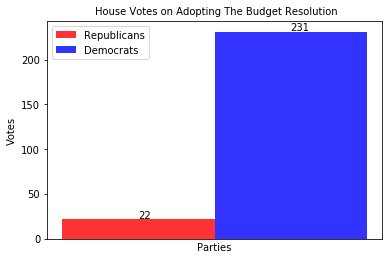

In [18]:
n_groups = 1
y1 = republicans['adoption-of-the-budget-resolution'].sum()
y2 = democrats['adoption-of-the-budget-resolution'].sum()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, y1, bar_width,alpha=opacity,color='r',label='Republicans')
rects2 = plt.bar(index + bar_width, y2, bar_width, alpha=opacity, color='b',label='Democrats')

plt.text(x =-0.1, y = 250, s = "House Votes on Adopting The Budget Resolution")
plt.xlabel('Parties')
plt.ylabel('Votes')
plt.text (x = 0, y = 23, s= '22')
plt.text (x = 0.35, y= 232,s= '231')

plt.xticks([])
plt.legend()
plt.show()

* The p-value is much less than 0.01. In this instance, you have to accept the null hypothesis that Democrats support the adoption of a a budget resolution more than the Repbulicans. 

Results: 
- T-Test results Ttest_indResult(statistic=23.12119107755175, 
- pvalue=6.013425749068062e-77)
- Average Republican votes 0.13496932515337423
- Average Democrat votes 0.8884615384615384



##3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01 


####Crime Bill

In [19]:
print('T-Test results', ttest_ind(republicans['crime'], democrats['crime'], nan_policy='omit'))
print('Average Republican votes', republicans['crime'].mean())
print('Average Democrat votes', democrats['crime'].mean())

T-Test results Ttest_indResult(statistic=16.288201256755894, pvalue=1.796481827173887e-46)
Average Republican votes 0.98125
Average Democrat votes 0.35019455252918286


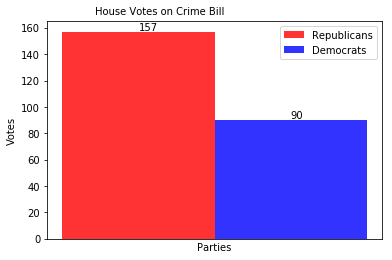

In [20]:
n_groups = 1
y1 = republicans['crime'].sum()
y2 = democrats['crime'].sum()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, y1, bar_width,alpha=opacity,color='r',label='Republicans')
rects2 = plt.bar(index + bar_width, y2, bar_width, alpha=opacity,color='b',label='Democrats')

plt.text(x =-0.1, y = 170, s = "House Votes on Crime Bill")
plt.xlabel('Parties')
plt.ylabel('Votes')

plt.text (x = 0,y = 158, s= '157')        
plt.text (x = 0.35, y= 91,s= '90')

plt.xticks([])
plt.legend()
plt.show()

* The p-value is much less than 0.01. In this instance, you have to accept the null hypothesis that Republicans support the crime bill more than the Democrats.

Results
- T-Test results Ttest_indResult(statistic=16.288201256755894, 
- pvalue=1.796481827173887e-46)
- Average Republican votes 0.98125
- Average Democrat votes 0.35019455252918286

##4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

####Water Project Cost Sharing

In [21]:
print('T-Test results', ttest_ind(republicans['water-project-cost-sharing'], democrats['water-project-cost-sharing'], nan_policy='omit'))
print('Average Republican votes', republicans['water-project-cost-sharing'].mean())
print('Average Democrat votes', democrats['water-project-cost-sharing'].mean())

T-Test results Ttest_indResult(statistic=0.02491808700047811, pvalue=0.9801332440121653)
Average Republican votes 0.5034013605442177
Average Democrat votes 0.502092050209205


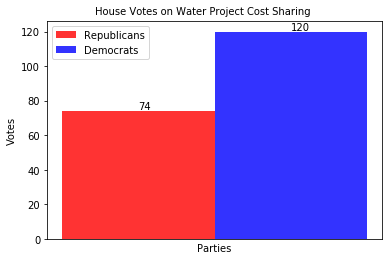

In [22]:
n_groups = 1
y1 = republicans['water-project-cost-sharing'].sum()
y2 = democrats['water-project-cost-sharing'].sum()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, y1, bar_width,alpha=opacity,color='r',label='Republicans')
rects2 = plt.bar(index + bar_width, y2, bar_width, alpha=opacity, color='b',label='Democrats')

plt.text(x =-0.1, y = 130, s = "House Votes on Water Project Cost Sharing")
plt.xlabel('Parties')
plt.ylabel('Votes')

plt.text (x = 0, y = 75, s= '74')        
plt.text (x = 0.35, y= 121, s= '120')

plt.xticks([])
plt.legend()
plt.show()

* With this issue the p-value is very close to 1 showing that both parties have similar view on the water project. 

Results: 
- T-Test results:  Ttest_indResult(statistic=0.02491808700047811, 
- pvalue=0.9801332440121653)
- Average Republican votes 0.5034013605442177
- Average Democrat votes 0.502092050209205

####Immigration

In [23]:
print('T-Test results', ttest_ind(republicans['immigration'], democrats['immigration'], nan_policy='omit'))
print('Average Republican votes', republicans['immigration'].mean())
print('Average Democrat votes', democrats['immigration'].mean())

T-Test results Ttest_indResult(statistic=1.677960615722372, pvalue=0.0940899398968142)
Average Republican votes 0.5548780487804879
Average Democrat votes 0.4714828897338403


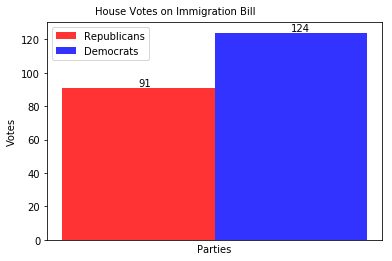

In [24]:
n_groups = 1
y1 = republicans['immigration'].sum()
y2 = democrats['immigration'].sum()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, y1, bar_width, alpha=opacity, color='r',label='Republicans')
rects2 = plt.bar(index + bar_width, y2,bar_width, alpha=opacity, color='b',label='Democrats')

plt.text(x =-0.1, y = 135, s = "House Votes on Immigration Bill")
plt.xlabel('Parties')
plt.ylabel('Votes')

plt.text (x = 0, y = 92, s= '91')
        
plt.text (x = 0.35, y= 125, s= '124')

plt.xticks([])
plt.legend()
plt.show()

* Immigration is another issue which both parties have similar voting patterns. 


Results: 
- T-Test results Ttest_indResult(statistic=1.677960615722372, 
- pvalue=0.0940899398968142)
- Average Republican votes 0.5548780487804879
- Average Democrat votes 0.4714828897338403

###Stretch Goal
###Refactor your code into functions so it's easy to rerun with arbitrary variables

#### Tried to create a function but this was too slow

In [0]:
def voting_results(x,y):
  partisan_test = ttest_ind(x, y, nan_policy='omit').pvalue
  print (partisan_test)
  if partisan_test < 0.01 and x.mean() > y.mean():
    print ("More Democrats than Republicans")
  elif partisan_test < 0.01 and x.mean() < y.mean():
    print ("More Republicans thans Democrats")
  else:
    print ("Toss up")

In [26]:
voting_results(democrats['export-administration-act-south-africa'], republicans['export-administration-act-south-africa'])

2.8060959129817107e-11
More Democrats than Republicans


In [27]:
voting_results(democrats['immigration'], republicans['immigration'])

0.0940899398968142
Toss up


In [28]:
voting_results(democrats['water-project-cost-sharing'], republicans['water-project-cost-sharing'])

0.9801332440121653
Toss up


####Created an ptest and means that would iterate through the columns and then created a dataframe of the values
- do not know why I had to create my dataframe in multiple steps but I get generating an error when I tried to add pvalue, and party means in one step

####T-test Table

In [34]:
#Columns
col = republicans.columns

#Pvalues
df3 = []
ptest = ttest_ind(republicans[col].values, democrats[col].values, nan_policy = 'omit').pvalue
df3.append(ptest)
df3
print(df3)

ttest_values = pd.DataFrame(col, df3)
ttest_values.reset_index(drop=False, inplace=True)
ttest_values = ttest_values.rename(columns = {'level_0':'PValue', 0:'Issue'})
ttest_values

ttest_values.reset_index(drop=False, inplace=True)
ttest_values = ttest_values.rename(columns = {'index':'#'})
ttest_values

[masked_array(data=[2.41955503e-018, 9.80133244e-001, 6.01342575e-077,
                   1.04011546e-176, 1.30355836e-067, 3.41542525e-020,
                   1.64142047e-030, 6.83553246e-054, 1.02551756e-046,
                   9.40899399e-002, 1.57593223e-015, 4.96761978e-064,
                   2.26287827e-034, 1.79648183e-046, 1.01197145e-031,
                   2.80609591e-011],
             mask=False,
       fill_value=1e+20)]


,#,PValue,Issue
0,0,2.419555e-18,handicapped-infants
1,1,9.801332e-01,water-project-cost-sharing
2,2,6.013426e-77,adoption-of-the-budget-resolution
3,3,1.040115e-176,physician-fee-freeze
4,4,1.303558e-67,el-salvador-aid
5,5,3.415425e-20,religious-groups-in-schools
6,6,1.641420e-30,anti-satellite-test-ban
7,7,6.835532e-54,aid-to-nicaraguan-contras
8,8,1.025518e-46,mx-missile
9,9,9.408994e-02,immigration


####Means Table

In [30]:
#Getting Republican Mean
rep_mean = []
mean_test = republicans.mean()
rep_mean.append(mean_test.values)
print('rep_mean', rep_mean)

#Getting Democrat Mean
dem_mean = []
mean_test1 = democrats.mean()
dem_mean.append(mean_test1.values)
print('dem_mean', dem_mean)

averages1 = pd.DataFrame(rep_mean).T
averages1.reset_index(drop=False, inplace=True)
averages1 = averages1.rename(columns = {'index':'#', 0:'Republican Average'})
averages1

averages2 = pd.DataFrame(dem_mean).T
averages2.reset_index(drop=False, inplace=True)
averages2 = averages2.rename(columns = {'index':'#', 0:'Democrat Average'})
averages2

merged = pd.merge(averages1, averages2)
merged

rep_mean [array([0.18902439, 0.50340136, 0.13496933, 0.98780488, 0.95121951,
       0.8969697 , 0.24223602, 0.15384615, 0.11585366, 0.55487805,
       0.13207547, 0.87012987, 0.85987261, 0.98125   , 0.09032258,
       0.65517241])]
dem_mean [array([0.60465116, 0.50209205, 0.88846154, 0.05405405, 0.21568627,
       0.47674419, 0.77220077, 0.82889734, 0.75806452, 0.47148289,
       0.50588235, 0.14457831, 0.28968254, 0.35019455, 0.6374502 ,
       0.93513514])]


,#,Republican Average,Democrat Average
0,0,0.189024,0.604651
1,1,0.503401,0.502092
2,2,0.134969,0.888462
3,3,0.987805,0.054054
4,4,0.951220,0.215686
5,5,0.896970,0.476744
6,6,0.242236,0.772201
7,7,0.153846,0.828897
8,8,0.115854,0.758065
9,9,0.554878,0.471483


####Merge PValues with Means

In [48]:
overall_statistic = pd.merge(ttest_values, merged,  how = 'outer')
overall_statistic

overall_statistic.drop('#', axis =1)
overall_statistic = overall_statistic[['Issue', 'PValue', 'Republican Average', 'Democrat Average']]
overall_statistic

,Issue,PValue,Republican Average,Democrat Average
0,handicapped-infants,2.419555e-18,0.189024,0.604651
1,water-project-cost-sharing,9.801332e-01,0.503401,0.502092
2,adoption-of-the-budget-resolution,6.013426e-77,0.134969,0.888462
3,physician-fee-freeze,1.040115e-176,0.987805,0.054054
4,el-salvador-aid,1.303558e-67,0.951220,0.215686
5,religious-groups-in-schools,3.415425e-20,0.896970,0.476744
6,anti-satellite-test-ban,1.641420e-30,0.242236,0.772201
7,aid-to-nicaraguan-contras,6.835532e-54,0.153846,0.828897
8,mx-missile,1.025518e-46,0.115854,0.758065
9,immigration,9.408994e-02,0.554878,0.471483


####Iterate through dataframe and created a new column to see if issues were partisan or not

Not sure why the if else statment does not work, I get the error that the 'return' outside function

Through persistence got this work (still confused how to write if/else statements and function)

In [53]:
# for ind, row in overall_statistic.iterrows():
#   overall_statistic.loc[ind, 'Partisan?'] = row['PValue'] <0.01 and row['Republican Average'] > row['Democrat Average']
#   if row['PValue'] <0.01 and row['Republican Average'] > row['Democrat Average']:
#      return('Republican')
#   elif row['PValue'] <0.01 and row['Republican Average'] < row['Democrat Average']:
#      return('Democrat')
#   else:
#      return('Toss up')


for ind, row in overall_statistic.iterrows():
  if row['PValue'] < 0.01 and row['Republican Average'] > row['Democrat Average']:
     overall_statistic.loc[ind, 'Partisan?'] = 'Republican'
  elif row['PValue'] < 0.01 and row['Republican Average'] < row['Democrat Average']:
     overall_statistic.loc[ind, 'Partisan?'] =  'Democrat'
  else:
     overall_statistic.loc[ind, 'Partisan?'] = 'Toss up'

overall_statistic['Partisan?']

0       Democrat
1        Toss up
2       Democrat
3     Republican
4     Republican
5     Republican
6       Democrat
7       Democrat
8       Democrat
9        Toss up
10      Democrat
11    Republican
12    Republican
13    Republican
14      Democrat
15      Democrat
Name: Partisan?, dtype: object

In [54]:
overall_statistic

,Issue,PValue,Republican Average,Democrat Average,Partisan?
0,handicapped-infants,2.419555e-18,0.189024,0.604651,Democrat
1,water-project-cost-sharing,9.801332e-01,0.503401,0.502092,Toss up
2,adoption-of-the-budget-resolution,6.013426e-77,0.134969,0.888462,Democrat
3,physician-fee-freeze,1.040115e-176,0.987805,0.054054,Republican
4,el-salvador-aid,1.303558e-67,0.951220,0.215686,Republican
5,religious-groups-in-schools,3.415425e-20,0.896970,0.476744,Republican
6,anti-satellite-test-ban,1.641420e-30,0.242236,0.772201,Democrat
7,aid-to-nicaraguan-contras,6.835532e-54,0.153846,0.828897,Democrat
8,mx-missile,1.025518e-46,0.115854,0.758065,Democrat
9,immigration,9.408994e-02,0.554878,0.471483,Toss up


####Created a function that generated a list of whether issues were partisan or not

In [33]:
def partisan_issue(row):
    row['PValue'] <0.01 and row['Republican Average'] > row['Democrat Average']
    if row['PValue'] <0.01 and row['Republican Average'] > row['Democrat Average']:
      return('Republican')
    elif row['PValue'] <0.01 and row['Republican Average'] < row['Democrat Average']:
      return('Democrat')
    else:
      return('Toss up')
    
overall_statistic.apply(partisan_issue, axis = 1)

0       Democrat
1        Toss up
2       Democrat
3     Republican
4     Republican
5     Republican
6       Democrat
7       Democrat
8       Democrat
9        Toss up
10      Democrat
11    Republican
12    Republican
13    Republican
14      Democrat
15      Democrat
dtype: object